In [ ]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import optuna
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


# Set global seed function
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If multiple GPUs are used
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
        torch.backends.cudnn.benchmark = False

Device: cuda


In [26]:
df = pd.read_csv('data_final/with_xal.csv')
old_train_df = df[df['set'] == 'train']
old_train_df.drop(columns=['set'], inplace=True)
test_df = df[df['set'] == 'test']
test_df.drop(columns=['set'], inplace=True)

# DEFINE VALIDATION SET AS THE LAST 25% OF THE TRAIN SET
first_75 = int(len(old_train_df)*0.75)
train_df = old_train_df[:first_75]
val_df = old_train_df[first_75:]

# Example for ensuring datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%Y-%m-%d')
val_df['Date'] = pd.to_datetime(val_df['Date'], format='%Y-%m-%d')
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%Y-%m-%d')

There are 5 work days in a week on median and 21 work days in a month on median. So, we will try to forecast using these horizons.

In [28]:
train_df.shape, val_df.shape, test_df.shape

((722, 8), (241, 8), (321, 8))

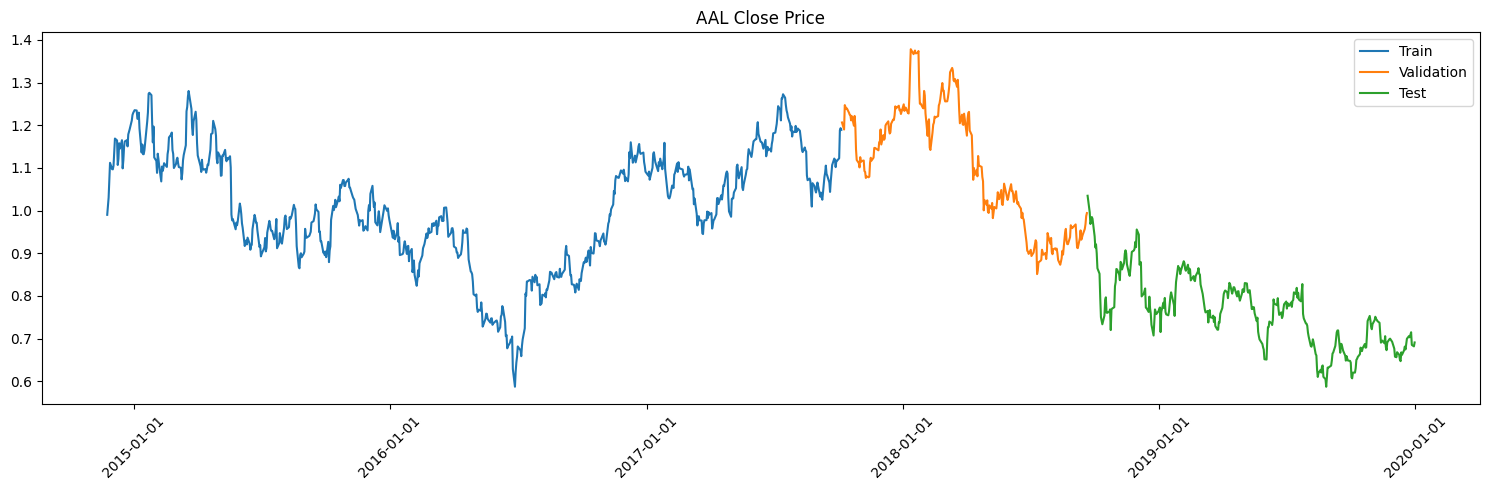

In [29]:
# Create the plot
plt.figure(figsize=(15, 5))

# Plot the data
plt.plot(train_df['Date'], train_df['Close'], label='Train')
plt.plot(val_df['Date'], val_df['Close'], label='Validation')
plt.plot(test_df['Date'], test_df['Close'], label='Test')

# Title and legend
plt.title('AAL Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

In [30]:
# create a train and test dataloader for forecasting H days ahead
H = 1
window_size = 20
use_cols = [0]
class TimeSeriesDataset(Dataset):
    def __init__(self, timeseries, H, use_cols, window_size):
        self.timeseries = timeseries
        self.H = H
        self.use_cols = use_cols
        self.window_size = window_size

        # if len(self.timeseries.shape) == 1:
        #     # If the time series shape [n], reshape it to [1, n]
        #     self.timeseries = self.timeseries.reshape(1, -1)
                    
    def __len__(self):
        # Ensure that we don't go out of bounds
        return self.timeseries.shape[0] - self.H - self.window_size + 1

    def __getitem__(self, idx):
        # Input: time series from the idx to idx + window_size
        input_series = self.timeseries[idx:idx+self.window_size, self.use_cols]
        # Target: time series from idx + window_size to idx + window_size + H
        #label = self.timeseries[idx+self.window_size:idx+self.window_size+self.H][:, 0]
        label = self.timeseries[idx+self.window_size+self.H-1, 0]
        return torch.tensor(input_series, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)

In [31]:
train_df_no_date = train_df.drop(columns=['Date'])
val_df_no_date = val_df.drop(columns=['Date'])
test_df_no_date = test_df.drop(columns=['Date'])

# Check and convert all DataFrame columns to numeric
train_df_no_date = train_df_no_date.apply(pd.to_numeric, errors='coerce')
val_df_no_date = val_df_no_date.apply(pd.to_numeric, errors='coerce')
test_df_no_date = test_df_no_date.apply(pd.to_numeric, errors='coerce')

# Fill NaN values (if any) with 0 or other appropriate values
train_df_no_date.fillna(0, inplace=True)
val_df_no_date.fillna(0, inplace=True)
test_df_no_date.fillna(0, inplace=True)

# Convert DataFrames to NumPy arrays with explicit dtype
train_array = train_df_no_date.values.astype(np.float32)
val_array = val_df_no_date.values.astype(np.float32)
test_array = test_df_no_date.values.astype(np.float32)

In [32]:
def create_datasets_and_loaders(train_array, val_array, test_array, H, window_size, use_cols, batch_size=4):
    # Create the training dataset and loader
    train_dataset = TimeSeriesDataset(train_array, H, use_cols, window_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    go_back = window_size + H - 1 # Number of days to go back to create the validation and test datasets, so predictions fit the target
    # Create the validation dataset and loader
    new_val_array = np.concatenate([train_array[-go_back:], val_array])
    val_dataset = TimeSeriesDataset(new_val_array, H, use_cols, window_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the test dataset and loader
    new_test_array = np.concatenate([new_val_array[-go_back:], test_array])
    test_dataset = TimeSeriesDataset(new_test_array, H, use_cols, window_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return (train_dataset, train_loader), (val_dataset, val_loader), (test_dataset, test_loader)

# LSTM

In [33]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layer for mapping to the output
        self.fc = nn.Linear(hidden_size, output_size)

        # Optional: Activation after the fully connected layer
        self.activation = nn.ReLU()

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out: [batch_size, seq_length, hidden_size]

        # Only take the last time step's hidden state
        out = self.fc(out[:, -1, :])  # out: [batch_size, output_size]

        # Apply activation function (optional)
        out = self.activation(out)

        return out.squeeze(-1)

In [34]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for input_data, labels in train_loader:
        # Move data to the device
        input_data, labels = input_data.to(device), labels.to(device)

        # Forward pass
        predictions = model(input_data)
        loss = criterion(predictions, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Average loss over all batches
    return train_loss

def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    avg_loss = 0.0
    predictions_list = []
    true_labels = []

    with torch.no_grad():
        for input_data, labels in data_loader:
            # Move data to the device
            input_data, labels = input_data.to(device), labels.to(device)

            # Forward pass
            predictions = model(input_data)
            loss = criterion(predictions, labels)

            avg_loss += loss.item()
            predictions_list.append(predictions.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    # Compute average loss
    avg_loss /= len(data_loader)

    # Flatten predictions and labels for RMSE calculation
    predictions_flat = np.concatenate(predictions_list).flatten()
    true_labels_flat = np.concatenate(true_labels).flatten()
    rmse = np.sqrt(mean_squared_error(true_labels_flat, predictions_flat))

    return avg_loss, rmse, predictions_list, true_labels

In [36]:
# Helper function for training with gradient clipping
def train_with_grad_clipping(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for input_data, labels in loader:
        input_data, labels = input_data.to(device), labels.to(device)
        predictions = model(input_data)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [37]:
def objective(trial, H, use_cols):
    # Set the seed for reproducibility
    set_seed(42)

    # Define hyperparameters to optimize
    hidden_size = trial.suggest_int('hidden_size', 32, 96, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0, 0.5)
    lr = trial.suggest_loguniform('lr', 5*1e-3, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16])

    # Initialize model, optimizer, etc.
    model = LSTMModel(input_size=len(use_cols), 
                      hidden_size=hidden_size, 
                      output_size=1, 
                      num_layers=num_layers, 
                      dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Track best model and validation RMSE
    best_val_rmse = float('inf')
    best_model_state = None

    # Train for multiple epochs
    for epoch in range(300):
        # Train the model and clip gradients for stability
        #train_loss = train_with_grad_clipping(model, train_loader, criterion, optimizer, device)
        train_loss = train(model, train_loader, criterion, optimizer, device)

        # Evaluate on validation set
        val_loss, val_rmse, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

        # Save the model state if validation RMSE improves
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Evaluate on the test set
    test_loss, test_rmse, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

    # Print results of the current trial
    print(f"Trial {trial.number}: "
          f"hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout:.2f}, "
          f"lr={lr:.5f}, batch_size={batch_size}, best_val_rmse={best_val_rmse:.4f}, test_rmse={test_rmse:.4f}")

    # Return the best validation RMSE for this trial
    return best_val_rmse  # Minimize RMSE

In [38]:
def run_optuna_with_progress(objective, H, use_cols, n_trials=1, seed=42, direction='minimize'):
    # Set seed for reproducibility
    set_seed(seed)
    optuna.logging.set_verbosity(optuna.logging.WARNING)  # Reduce logging verbosity

    # Create progress bar
    with tqdm(total=n_trials) as pbar:
        def wrapped_objective(trial):
            # Call the objective function and update progress bar
            result = objective(trial, H, use_cols)
            pbar.update(1)
            return result

        # Initialize and optimize the study
        study = optuna.create_study(direction=direction)
        study.optimize(wrapped_objective, n_trials=n_trials)
    
    # Output the best hyperparameters and value
    print("\nBest hyperparameters:", study.best_params)
    print("Best RMSE:", study.best_value)
    return study

In [39]:
def train_and_evaluate_lstm_model(study_best_params, train_dataset, val_dataset, test_dataset, use_cols, H, device):
    # Extract hyperparameters
    best_params = study_best_params
    hidden_size = best_params['hidden_size']
    num_layers = best_params['num_layers']
    dropout = best_params['dropout']
    lr = best_params['lr']
    batch_size = best_params['batch_size']

    set_seed(42)  # Ensure reproducibility

    # Initialize model, criterion, and optimizer
    model = LSTMModel(input_size=len(use_cols), 
                      hidden_size=hidden_size, 
                      output_size=1, 
                      num_layers=num_layers, 
                      dropout=dropout).to(device)
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    best_val_rmse = float('inf')
    best_model_state = None

    for epoch in range(400):  # Use more epochs to refine optimization
        train(model, train_loader, criterion, optimizer, device)

        # Evaluate on validation set
        val_loss, val_rmse, _, _ = evaluate(model, val_loader, criterion, device)

        # Save the model state if validation RMSE improves
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = model.state_dict()

        # Optional: Print epoch-level progress
        print(f"Epoch [{epoch+1}/400]: Val Loss={val_loss:.4f}, Val RMSE={val_rmse:.4f} (Best RMSE={best_val_rmse:.4f})")

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Evaluate on train, val, and test sets
    train_loss, train_rmse, train_preds, train_labels = evaluate(model, train_loader, criterion, device)
    val_loss, val_rmse, val_preds, val_labels = evaluate(model, val_loader, criterion, device)
    test_loss, test_rmse, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

    # Print test RMSE
    print(f"Test RMSE: {test_rmse:.4f}")

    # Return predictions and RMSEs
    return {
        "train": {"rmse": train_rmse, "preds": train_preds, "labels": train_labels},
        "val": {"rmse": val_rmse, "preds": val_preds, "labels": val_labels},
        "test": {"rmse": test_rmse, "preds": test_preds, "labels": test_labels}
    }

In [40]:
def plot_predictions_with_actuals(train_preds, val_preds, test_preds, 
                                  train_rmse, val_rmse, test_rmse, 
                                  train_df, val_df, test_df, 
                                  window_size, H, use_cols):
    # Flatten predictions
    #train_preds_flat = np.concatenate(train_preds).flatten()
    val_preds_flat = np.concatenate(val_preds).flatten()
    test_preds_flat = np.concatenate(test_preds).flatten()
    

    # Extract relevant dates
    train_dates = train_df['Date'].values
    val_dates = val_df['Date'].values
    test_dates = test_df['Date'].values

    # Create the plot
    plt.figure(figsize=(15, 5))

    columns = train_df.columns
    #print(f"all columns: {columns}")
    used_column_names = [columns[i+1] for i in use_cols]
    #print(f"used_column_names: {used_column_names}")

    # Plot the original data
    plt.plot(train_df['Date'], train_df[columns[1]], label='Train', alpha=0.8)
    plt.plot(val_df['Date'], val_df[columns[1]], label='Validation', alpha=0.8)
    plt.plot(test_df['Date'], test_df[columns[1]], label='Test', alpha=0.8)

    # Plot the predictions
    #plt.plot(train_dates, train_preds_flat, label=f'Train Predictions (rmse={train_rmse:.2f})', linestyle='--', color='blue')
    plt.plot(val_dates, val_preds_flat, label=f'Validation Predictions (rmse={val_rmse:.2f})', linestyle='--', color='orange')
    plt.plot(test_dates, test_preds_flat, label=f'Test Predictions (rmse={test_rmse:.2f})', linestyle='--', color='green')

    # Title, legend, and formatting
    plt.title(f'Predictions vs Actuals (Window Size={window_size}, Horizon={H}, Features={used_column_names})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.tight_layout()
    plt.show()

## Horizon = 1

### Only using AAL

In [41]:
H = 1
window_size = 20
use_cols = [0]
batch_size = 4

(train_dataset, train_loader), (val_dataset, val_loader), (test_dataset, test_loader) = create_datasets_and_loaders(
    train_array=train_array,
    val_array=val_array,
    test_array=test_array,
    H=H,
    window_size=window_size,
    use_cols=use_cols,
    batch_size=batch_size
)

# How to access the data in the DataLoader
for input_data, label in train_loader:
    print(input_data.shape, label.shape)
    break

torch.Size([4, 20, 1]) torch.Size([4])


In [42]:
study = run_optuna_with_progress(objective, H, use_cols, n_trials=10, seed=42, direction='minimize')

  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa7df059ea0>>
Traceback (most recent call last):
  File "/home/romh/miniconda3/envs/other/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
  File "_pydevd_bundle/pydevd_cython.pyx", line 1457, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle/pydevd_cython.pyx", line 1758, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "/home/romh/miniconda3/envs/other/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_is_thread_alive.py", line 9, in is_thread_alive
    def is_thread_alive(t):
KeyboardInterrupt: 
 10%|█         | 1/10 [02:14<20:13, 134.89s/it]

Trial 0: hidden_size=64, num_layers=1, dropout=0.43, lr=0.00720, batch_size=16, best_val_rmse=0.0221, test_rmse=0.0212


 20%|██        | 2/10 [06:07<25:37, 192.24s/it]

Trial 1: hidden_size=96, num_layers=3, dropout=0.23, lr=0.00856, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 30%|███       | 3/10 [14:19<38:25, 329.29s/it]

Trial 2: hidden_size=64, num_layers=4, dropout=0.21, lr=0.00701, batch_size=4, best_val_rmse=1.1106, test_rmse=0.7658


 40%|████      | 4/10 [17:35<27:38, 276.42s/it]

Trial 3: hidden_size=64, num_layers=2, dropout=0.33, lr=0.00593, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 50%|█████     | 5/10 [19:51<18:49, 225.87s/it]

Trial 4: hidden_size=96, num_layers=1, dropout=0.17, lr=0.00798, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 60%|██████    | 6/10 [22:08<13:03, 195.76s/it]

Trial 5: hidden_size=96, num_layers=1, dropout=0.44, lr=0.00996, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 70%|███████   | 7/10 [23:52<08:17, 165.84s/it]

Trial 6: hidden_size=64, num_layers=2, dropout=0.03, lr=0.00711, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 80%|████████  | 8/10 [28:18<06:34, 197.49s/it]

Trial 7: hidden_size=96, num_layers=4, dropout=0.39, lr=0.00889, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 90%|█████████ | 9/10 [30:34<02:58, 178.52s/it]

Trial 8: hidden_size=64, num_layers=1, dropout=0.49, lr=0.00633, batch_size=8, best_val_rmse=0.0222, test_rmse=0.0194


100%|██████████| 10/10 [37:47<00:00, 226.72s/it]

Trial 9: hidden_size=32, num_layers=3, dropout=0.05, lr=0.00640, batch_size=4, best_val_rmse=0.0233, test_rmse=0.0327

Best hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.4336336681210448, 'lr': 0.007204042453967384, 'batch_size': 16}
Best RMSE: 0.022098958492279053


In [ ]:
results = train_and_evaluate_lstm_model(
    study_best_params=study.best_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    use_cols=use_cols,
    H=H,
    device=device
)

# Access train, val, and test results
# rmses
train_rmse, val_rmse, test_rmse = results['train']['rmse'], results['val']['rmse'], results['test']['rmse']
# preds
train_preds, val_preds, test_preds = results['train']['preds'], results['val']['preds'], results['test']['preds']

Epoch [1/400]: Val Loss=0.0147, Val RMSE=0.1230 (Best RMSE=0.1230)
Epoch [2/400]: Val Loss=0.0022, Val RMSE=0.0468 (Best RMSE=0.0468)


Epoch [3/400]: Val Loss=0.0018, Val RMSE=0.0421 (Best RMSE=0.0421)
Epoch [4/400]: Val Loss=0.0031, Val RMSE=0.0560 (Best RMSE=0.0421)
Epoch [5/400]: Val Loss=0.0017, Val RMSE=0.0414 (Best RMSE=0.0414)
Epoch [6/400]: Val Loss=0.0015, Val RMSE=0.0397 (Best RMSE=0.0397)
Epoch [7/400]: Val Loss=0.0009, Val RMSE=0.0297 (Best RMSE=0.0297)
Epoch [8/400]: Val Loss=0.0012, Val RMSE=0.0345 (Best RMSE=0.0297)
Epoch [9/400]: Val Loss=0.0008, Val RMSE=0.0277 (Best RMSE=0.0277)
Epoch [10/400]: Val Loss=0.0019, Val RMSE=0.0440 (Best RMSE=0.0277)
Epoch [11/400]: Val Loss=0.0023, Val RMSE=0.0476 (Best RMSE=0.0277)
Epoch [12/400]: Val Loss=0.0006, Val RMSE=0.0256 (Best RMSE=0.0256)
Epoch [13/400]: Val Loss=0.0007, Val RMSE=0.0266 (Best RMSE=0.0256)
Epoch [14/400]: Val Loss=0.0012, Val RMSE=0.0351 (Best RMSE=0.0256)
Epoch [15/400]: Val Loss=0.0010, Val RMSE=0.0321 (Best RMSE=0.0256)
Epoch [16/400]: Val Loss=0.0008, Val RMSE=0.0276 (Best RMSE=0.0256)
Epoch [17/400]: Val Loss=0.0010, Val RMSE=0.0316 (Best 

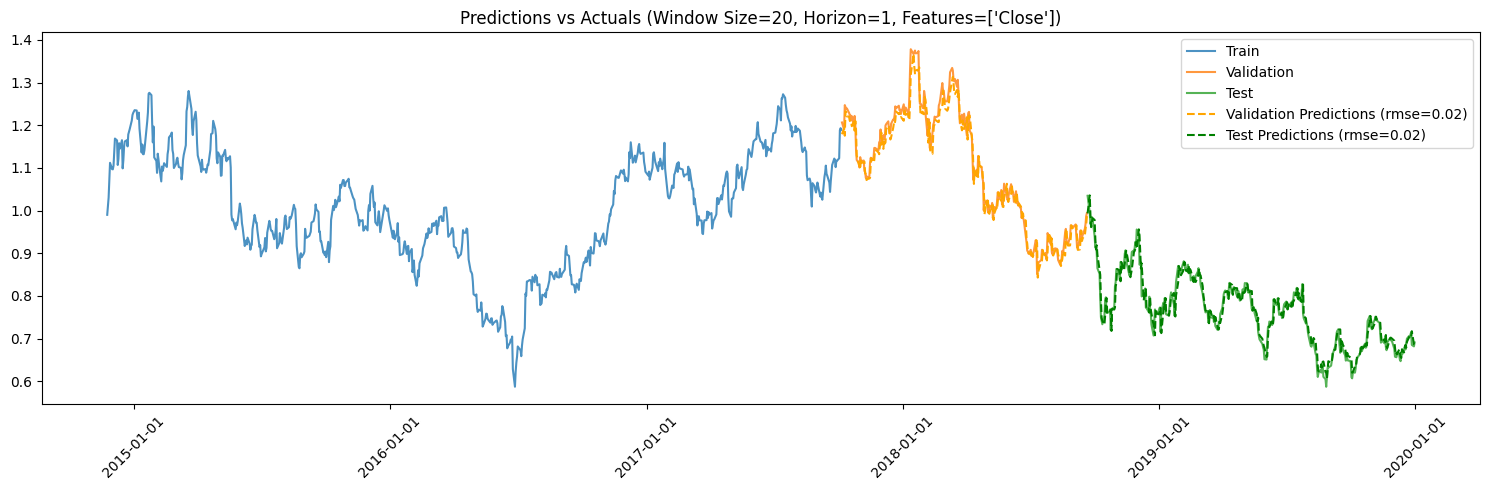

In [ ]:
plot_predictions_with_actuals(train_preds, val_preds, test_preds, 
                                train_rmse, val_rmse, test_rmse, 
                                train_df, val_df, test_df, 
                                window_size, H, use_cols)

In [ ]:
# create predictions folder
pred_path = 'predictions/predictions_LSTM/'
import os
if not os.path.exists(pred_path):
    os.makedirs(pred_path)

# save predictions on test set to new df
test_preds_flat = np.concatenate(test_preds).flatten()
test_dates = test_df['Date'].values

test_preds_df = pd.DataFrame({'Date': test_dates, 'Close': test_preds_flat})
test_preds_df.to_csv(pred_path + f'LSTM_1.csv', index=False)

### More Features

In [ ]:
# more features
H = 1
window_size = 20
use_cols = [0, 2, 3, 5]
batch_size = 4

(train_dataset, train_loader), (val_dataset, val_loader), (test_dataset, test_loader) = create_datasets_and_loaders(
    train_array=train_array,
    val_array=val_array,
    test_array=test_array,
    H=H,
    window_size=window_size,
    use_cols=use_cols,
    batch_size=batch_size
)

# How to access the data in the DataLoader
for input_data, label in train_loader:
    print(input_data.shape, label.shape)
    break

torch.Size([4, 20, 4]) torch.Size([4])


In [ ]:
study = run_optuna_with_progress(objective, H, use_cols, n_trials=10, seed=42, direction='minimize')

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [15:40<2:21:02, 940.22s/it]

Trial 0: hidden_size=64, num_layers=1, dropout=0.03, lr=0.00604, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 20%|██        | 2/10 [31:10<2:04:33, 934.23s/it]

Trial 1: hidden_size=32, num_layers=1, dropout=0.08, lr=0.00806, batch_size=8, best_val_rmse=0.0229, test_rmse=0.0233


 30%|███       | 3/10 [43:42<1:39:16, 850.95s/it]

Trial 2: hidden_size=64, num_layers=1, dropout=0.31, lr=0.00649, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 40%|████      | 4/10 [1:10:09<1:54:09, 1141.58s/it]

Trial 3: hidden_size=96, num_layers=4, dropout=0.15, lr=0.00667, batch_size=4, best_val_rmse=0.0235, test_rmse=0.3196


 50%|█████     | 5/10 [1:29:29<1:35:41, 1148.23s/it]

Trial 4: hidden_size=96, num_layers=4, dropout=0.19, lr=0.00741, batch_size=8, best_val_rmse=0.0254, test_rmse=0.0714


 60%|██████    | 6/10 [1:48:33<1:16:27, 1146.89s/it]

Trial 5: hidden_size=96, num_layers=4, dropout=0.22, lr=0.00842, batch_size=8, best_val_rmse=0.1465, test_rmse=0.7658


 70%|███████   | 7/10 [2:03:27<53:12, 1064.10s/it]  

Trial 6: hidden_size=96, num_layers=4, dropout=0.36, lr=0.00556, batch_size=16, best_val_rmse=0.0241, test_rmse=0.0973


 80%|████████  | 8/10 [2:29:28<40:44, 1222.37s/it]

Trial 7: hidden_size=32, num_layers=4, dropout=0.17, lr=0.00585, batch_size=4, best_val_rmse=0.0313, test_rmse=0.0802


 90%|█████████ | 9/10 [2:45:29<19:00, 1140.68s/it]

Trial 8: hidden_size=64, num_layers=1, dropout=0.32, lr=0.00887, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


100%|██████████| 10/10 [2:59:44<00:00, 1078.40s/it]

Trial 9: hidden_size=64, num_layers=3, dropout=0.30, lr=0.00750, batch_size=16, best_val_rmse=0.0239, test_rmse=0.1199

Best hyperparameters: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.07638417620358523, 'lr': 0.008061169861410858, 'batch_size': 8}
Best RMSE: 0.022896287962794304


In [ ]:
results = train_and_evaluate_lstm_model(
    study_best_params=study.best_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    use_cols=use_cols,
    H=H,
    device=device
)

# Access train, val, and test results
# rmses
train_rmse, val_rmse, test_rmse = results['train']['rmse'], results['val']['rmse'], results['test']['rmse']
# preds
train_preds, val_preds, test_preds = results['train']['preds'], results['val']['preds'], results['test']['preds']

Epoch [1/400]: Val Loss=0.0213, Val RMSE=0.1478 (Best RMSE=0.1478)
Epoch [2/400]: Val Loss=0.0158, Val RMSE=0.1242 (Best RMSE=0.1242)
Epoch [3/400]: Val Loss=0.0040, Val RMSE=0.0637 (Best RMSE=0.0637)
Epoch [4/400]: Val Loss=0.0036, Val RMSE=0.0602 (Best RMSE=0.0602)
Epoch [5/400]: Val Loss=0.0023, Val RMSE=0.0487 (Best RMSE=0.0487)
Epoch [6/400]: Val Loss=0.0010, Val RMSE=0.0326 (Best RMSE=0.0326)
Epoch [7/400]: Val Loss=0.0018, Val RMSE=0.0426 (Best RMSE=0.0326)
Epoch [8/400]: Val Loss=0.0023, Val RMSE=0.0478 (Best RMSE=0.0326)
Epoch [9/400]: Val Loss=0.0012, Val RMSE=0.0357 (Best RMSE=0.0326)
Epoch [10/400]: Val Loss=0.0017, Val RMSE=0.0421 (Best RMSE=0.0326)
Epoch [11/400]: Val Loss=0.0018, Val RMSE=0.0425 (Best RMSE=0.0326)
Epoch [12/400]: Val Loss=0.0013, Val RMSE=0.0357 (Best RMSE=0.0326)
Epoch [13/400]: Val Loss=0.0007, Val RMSE=0.0274 (Best RMSE=0.0274)


Epoch [14/400]: Val Loss=0.0007, Val RMSE=0.0259 (Best RMSE=0.0259)
Epoch [15/400]: Val Loss=0.0006, Val RMSE=0.0249 (Best RMSE=0.0249)
Epoch [16/400]: Val Loss=0.0006, Val RMSE=0.0258 (Best RMSE=0.0249)
Epoch [17/400]: Val Loss=0.0006, Val RMSE=0.0251 (Best RMSE=0.0249)
Epoch [18/400]: Val Loss=0.0006, Val RMSE=0.0246 (Best RMSE=0.0246)
Epoch [19/400]: Val Loss=0.0010, Val RMSE=0.0315 (Best RMSE=0.0246)
Epoch [20/400]: Val Loss=0.0017, Val RMSE=0.0413 (Best RMSE=0.0246)
Epoch [21/400]: Val Loss=0.0008, Val RMSE=0.0281 (Best RMSE=0.0246)
Epoch [22/400]: Val Loss=0.0005, Val RMSE=0.0229 (Best RMSE=0.0229)
Epoch [23/400]: Val Loss=0.0006, Val RMSE=0.0257 (Best RMSE=0.0229)
Epoch [24/400]: Val Loss=0.0014, Val RMSE=0.0375 (Best RMSE=0.0229)
Epoch [25/400]: Val Loss=0.0007, Val RMSE=0.0272 (Best RMSE=0.0229)
Epoch [26/400]: Val Loss=0.0006, Val RMSE=0.0254 (Best RMSE=0.0229)
Epoch [27/400]: Val Loss=0.0019, Val RMSE=0.0430 (Best RMSE=0.0229)
Epoch [28/400]: Val Loss=0.0009, Val RMSE=0.0300

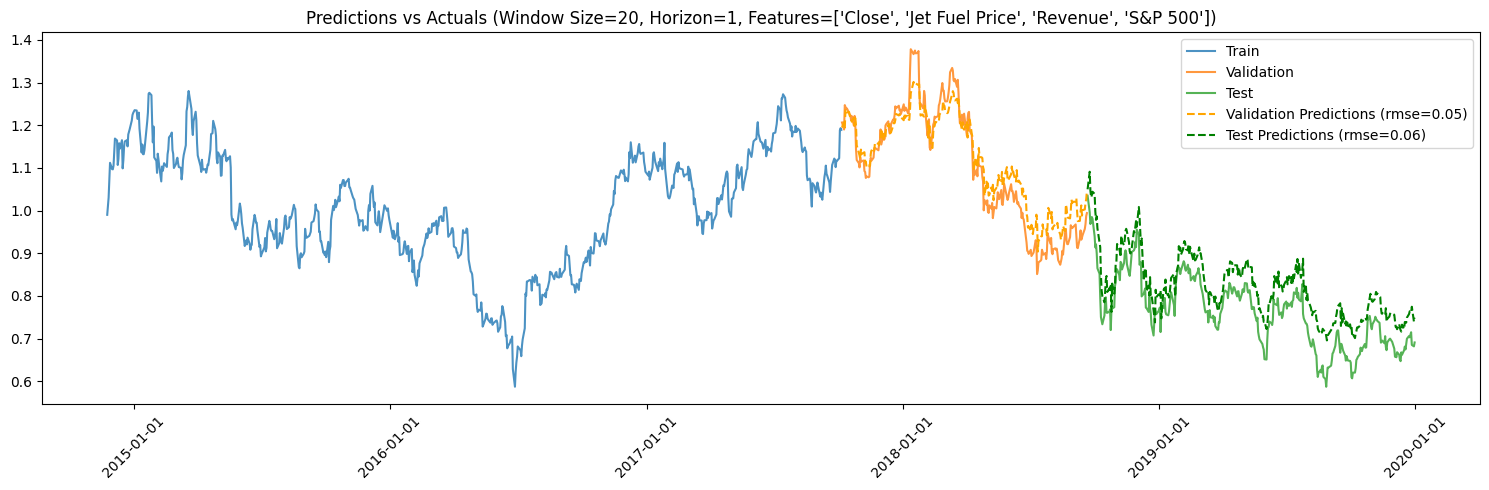

In [ ]:
plot_predictions_with_actuals(train_preds, val_preds, test_preds, 
                                train_rmse, val_rmse, test_rmse, 
                                train_df, val_df, test_df, 
                                window_size, H, use_cols)

In [ ]:
# save predictions on test set to new df
test_preds_flat = np.concatenate(test_preds).flatten()
test_dates = test_df['Date'].values

test_preds_df = pd.DataFrame({'Date': test_dates, 'Close': test_preds_flat})
test_preds_df.to_csv(pred_path + f'LSTM_1_ex.csv', index=False)

## Horizon = 5 (work week)

### Only using AAL

In [ ]:
H = 5
window_size = 20
use_cols = [0]
batch_size = 4

(train_dataset, train_loader), (val_dataset, val_loader), (test_dataset, test_loader) = create_datasets_and_loaders(
    train_array=train_array,
    val_array=val_array,
    test_array=test_array,
    H=H,
    window_size=window_size,
    use_cols=use_cols,
    batch_size=batch_size
)

# How to access the data in the DataLoader
for input_data, label in train_loader:
    print(input_data.shape, label.shape)
    break

torch.Size([4, 20, 1]) torch.Size([4])


In [ ]:
study = run_optuna_with_progress(objective, H, use_cols, n_trials=10, seed=42, direction='minimize')

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [17:11<2:34:47, 1031.98s/it]

Trial 0: hidden_size=96, num_layers=2, dropout=0.05, lr=0.00657, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 20%|██        | 2/10 [38:44<2:38:01, 1185.18s/it]

Trial 1: hidden_size=64, num_layers=1, dropout=0.24, lr=0.00955, batch_size=4, best_val_rmse=0.0498, test_rmse=0.0596


 30%|███       | 3/10 [52:06<1:57:53, 1010.48s/it]

Trial 2: hidden_size=96, num_layers=3, dropout=0.49, lr=0.00559, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 40%|████      | 4/10 [1:10:42<1:45:10, 1051.79s/it]

Trial 3: hidden_size=64, num_layers=3, dropout=0.31, lr=0.00823, batch_size=8, best_val_rmse=0.0550, test_rmse=0.0661


 50%|█████     | 5/10 [1:24:59<1:21:48, 981.67s/it] 

Trial 4: hidden_size=32, num_layers=4, dropout=0.08, lr=0.00520, batch_size=16, best_val_rmse=0.0527, test_rmse=0.0755


 60%|██████    | 6/10 [1:49:47<1:16:54, 1153.75s/it]

Trial 5: hidden_size=64, num_layers=3, dropout=0.07, lr=0.00829, batch_size=4, best_val_rmse=0.0541, test_rmse=0.0723


 70%|███████   | 7/10 [2:01:57<50:45, 1015.25s/it]  

Trial 6: hidden_size=32, num_layers=1, dropout=0.14, lr=0.00770, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 80%|████████  | 8/10 [2:15:16<31:32, 946.42s/it] 

Trial 7: hidden_size=64, num_layers=3, dropout=0.38, lr=0.00602, batch_size=16, best_val_rmse=0.0544, test_rmse=0.0732


 90%|█████████ | 9/10 [2:28:54<15:06, 906.24s/it]

Trial 8: hidden_size=64, num_layers=2, dropout=0.32, lr=0.00592, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


100%|██████████| 10/10 [2:44:11<00:00, 985.20s/it]

Trial 9: hidden_size=32, num_layers=1, dropout=0.06, lr=0.00527, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658

Best hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.23838209435044966, 'lr': 0.009548176551988263, 'batch_size': 4}
Best RMSE: 0.049830760806798935


In [ ]:
results = train_and_evaluate_lstm_model(
    study_best_params=study.best_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    use_cols=use_cols,
    H=H,
    device=device
)

# Access train, val, and test results
# rmses
train_rmse, val_rmse, test_rmse = results['train']['rmse'], results['val']['rmse'], results['test']['rmse']
# preds
train_preds, val_preds, test_preds = results['train']['preds'], results['val']['preds'], results['test']['preds']

Epoch [1/400]: Val Loss=0.0071, Val RMSE=0.0842 (Best RMSE=0.0842)
Epoch [2/400]: Val Loss=0.0040, Val RMSE=0.0631 (Best RMSE=0.0631)


Epoch [3/400]: Val Loss=0.0040, Val RMSE=0.0630 (Best RMSE=0.0630)
Epoch [4/400]: Val Loss=0.0030, Val RMSE=0.0544 (Best RMSE=0.0544)
Epoch [5/400]: Val Loss=0.0029, Val RMSE=0.0541 (Best RMSE=0.0541)
Epoch [6/400]: Val Loss=0.0041, Val RMSE=0.0635 (Best RMSE=0.0541)
Epoch [7/400]: Val Loss=0.0051, Val RMSE=0.0710 (Best RMSE=0.0541)
Epoch [8/400]: Val Loss=0.0028, Val RMSE=0.0529 (Best RMSE=0.0529)
Epoch [9/400]: Val Loss=0.0026, Val RMSE=0.0511 (Best RMSE=0.0511)
Epoch [10/400]: Val Loss=0.0025, Val RMSE=0.0498 (Best RMSE=0.0498)
Epoch [11/400]: Val Loss=0.0096, Val RMSE=0.0981 (Best RMSE=0.0498)
Epoch [12/400]: Val Loss=0.0032, Val RMSE=0.0564 (Best RMSE=0.0498)
Epoch [13/400]: Val Loss=0.0032, Val RMSE=0.0566 (Best RMSE=0.0498)
Epoch [14/400]: Val Loss=0.0037, Val RMSE=0.0608 (Best RMSE=0.0498)
Epoch [15/400]: Val Loss=0.0026, Val RMSE=0.0511 (Best RMSE=0.0498)
Epoch [16/400]: Val Loss=0.0026, Val RMSE=0.0510 (Best RMSE=0.0498)
Epoch [17/400]: Val Loss=0.0026, Val RMSE=0.0513 (Best 

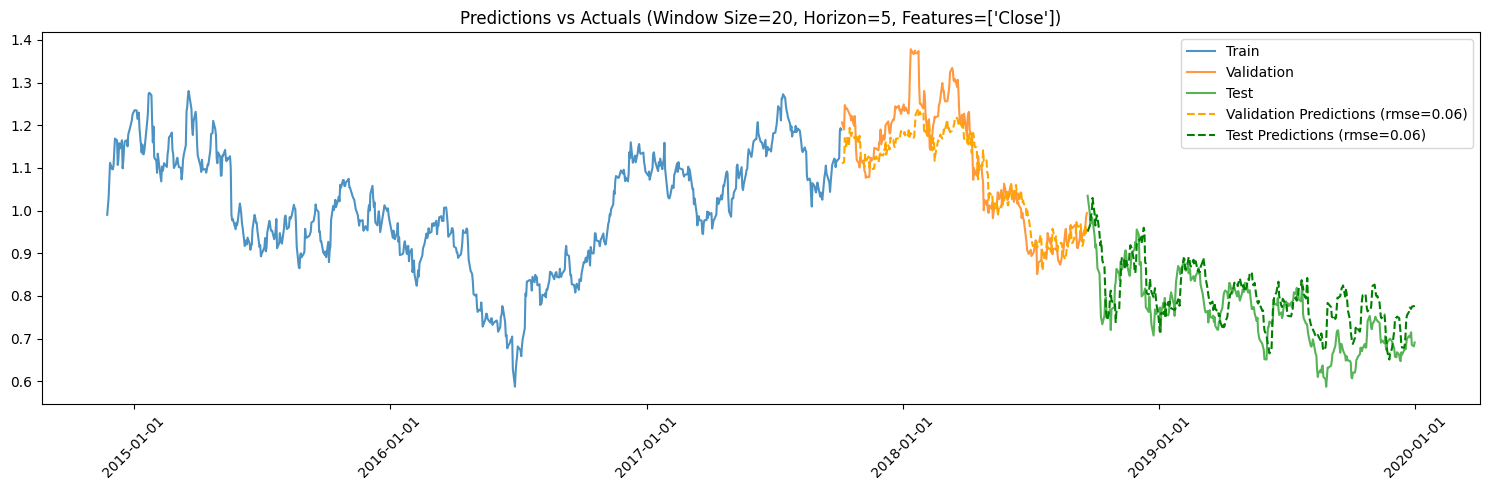

In [ ]:
plot_predictions_with_actuals(train_preds, val_preds, test_preds,
                                train_rmse, val_rmse, test_rmse,
                                train_df, val_df, test_df,
                                window_size, H, use_cols)

In [ ]:
# save predictions on test set to new df
test_preds_flat = np.concatenate(test_preds).flatten()
test_dates = test_df['Date'].values

test_preds_df = pd.DataFrame({'Date': test_dates, 'Close': test_preds_flat})
test_preds_df.to_csv(pred_path + f'LSTM_5.csv', index=False)

### More Features

In [ ]:
H = 5
window_size = 20
use_cols = [0, 2, 3, 5]
batch_size = 4

(train_dataset, train_loader), (val_dataset, val_loader), (test_dataset, test_loader) = create_datasets_and_loaders(
    train_array=train_array,
    val_array=val_array,
    test_array=test_array,
    H=H,
    window_size=window_size,
    use_cols=use_cols,
    batch_size=batch_size
)

# How to access the data in the DataLoader
for input_data, label in train_loader:
    print(input_data.shape, label.shape)
    break

torch.Size([4, 20, 4]) torch.Size([4])


In [ ]:
study = run_optuna_with_progress(objective, H, use_cols, n_trials=10, seed=42, direction='minimize')

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [16:51<2:31:39, 1011.00s/it]

Trial 0: hidden_size=32, num_layers=2, dropout=0.28, lr=0.00525, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 20%|██        | 2/10 [32:01<2:06:53, 951.75s/it] 

Trial 1: hidden_size=96, num_layers=4, dropout=0.45, lr=0.00786, batch_size=16, best_val_rmse=0.0677, test_rmse=0.3384


 30%|███       | 3/10 [45:21<1:42:57, 882.47s/it]

Trial 2: hidden_size=32, num_layers=3, dropout=0.22, lr=0.00565, batch_size=16, best_val_rmse=0.0660, test_rmse=0.1951


 40%|████      | 4/10 [1:08:34<1:48:24, 1084.06s/it]

Trial 3: hidden_size=64, num_layers=2, dropout=0.42, lr=0.00876, batch_size=4, best_val_rmse=0.0597, test_rmse=0.1644


 50%|█████     | 5/10 [1:25:49<1:28:51, 1066.31s/it]

Trial 4: hidden_size=96, num_layers=2, dropout=0.04, lr=0.00594, batch_size=8, best_val_rmse=0.0565, test_rmse=0.2768


 60%|██████    | 6/10 [1:40:51<1:07:22, 1010.54s/it]

Trial 5: hidden_size=64, num_layers=4, dropout=0.45, lr=0.00651, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 70%|███████   | 7/10 [2:06:34<59:13, 1184.54s/it]  

Trial 6: hidden_size=96, num_layers=4, dropout=0.38, lr=0.00572, batch_size=4, best_val_rmse=0.0677, test_rmse=0.2473


 80%|████████  | 8/10 [2:25:59<39:17, 1178.52s/it]

Trial 7: hidden_size=96, num_layers=4, dropout=0.47, lr=0.00637, batch_size=8, best_val_rmse=0.0694, test_rmse=0.2973


 90%|█████████ | 9/10 [2:47:16<20:09, 1209.32s/it]

Trial 8: hidden_size=96, num_layers=1, dropout=0.10, lr=0.00512, batch_size=4, best_val_rmse=0.0539, test_rmse=0.1647


100%|██████████| 10/10 [3:01:42<00:00, 1090.29s/it]

Trial 9: hidden_size=96, num_layers=4, dropout=0.04, lr=0.00859, batch_size=16, best_val_rmse=0.0676, test_rmse=0.3531

Best hyperparameters: {'hidden_size': 96, 'num_layers': 1, 'dropout': 0.10038385486528778, 'lr': 0.005115148681710976, 'batch_size': 4}
Best RMSE: 0.05389458313584328


In [ ]:
results = train_and_evaluate_lstm_model(
    study_best_params=study.best_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    use_cols=use_cols,
    H=H,
    device=device
)

# Access train, val, and test results
# rmses
train_rmse, val_rmse, test_rmse = results['train']['rmse'], results['val']['rmse'], results['test']['rmse']
# preds
train_preds, val_preds, test_preds = results['train']['preds'], results['val']['preds'], results['test']['preds']

Epoch [1/400]: Val Loss=0.0222, Val RMSE=0.1486 (Best RMSE=0.1486)
Epoch [2/400]: Val Loss=0.0084, Val RMSE=0.0916 (Best RMSE=0.0916)
Epoch [3/400]: Val Loss=0.0108, Val RMSE=0.1037 (Best RMSE=0.0916)
Epoch [4/400]: Val Loss=0.0082, Val RMSE=0.0909 (Best RMSE=0.0909)


Epoch [5/400]: Val Loss=0.0061, Val RMSE=0.0785 (Best RMSE=0.0785)
Epoch [6/400]: Val Loss=0.0043, Val RMSE=0.0658 (Best RMSE=0.0658)
Epoch [7/400]: Val Loss=0.0040, Val RMSE=0.0633 (Best RMSE=0.0633)
Epoch [8/400]: Val Loss=0.0030, Val RMSE=0.0550 (Best RMSE=0.0550)
Epoch [9/400]: Val Loss=0.0037, Val RMSE=0.0610 (Best RMSE=0.0550)
Epoch [10/400]: Val Loss=0.0035, Val RMSE=0.0594 (Best RMSE=0.0550)
Epoch [11/400]: Val Loss=0.0041, Val RMSE=0.0642 (Best RMSE=0.0550)
Epoch [12/400]: Val Loss=0.0048, Val RMSE=0.0697 (Best RMSE=0.0550)
Epoch [13/400]: Val Loss=0.0052, Val RMSE=0.0725 (Best RMSE=0.0550)
Epoch [14/400]: Val Loss=0.0049, Val RMSE=0.0702 (Best RMSE=0.0550)
Epoch [15/400]: Val Loss=0.0035, Val RMSE=0.0592 (Best RMSE=0.0550)
Epoch [16/400]: Val Loss=0.0046, Val RMSE=0.0681 (Best RMSE=0.0550)
Epoch [17/400]: Val Loss=0.0036, Val RMSE=0.0600 (Best RMSE=0.0550)
Epoch [18/400]: Val Loss=0.0033, Val RMSE=0.0578 (Best RMSE=0.0550)
Epoch [19/400]: Val Loss=0.0030, Val RMSE=0.0551 (Bes

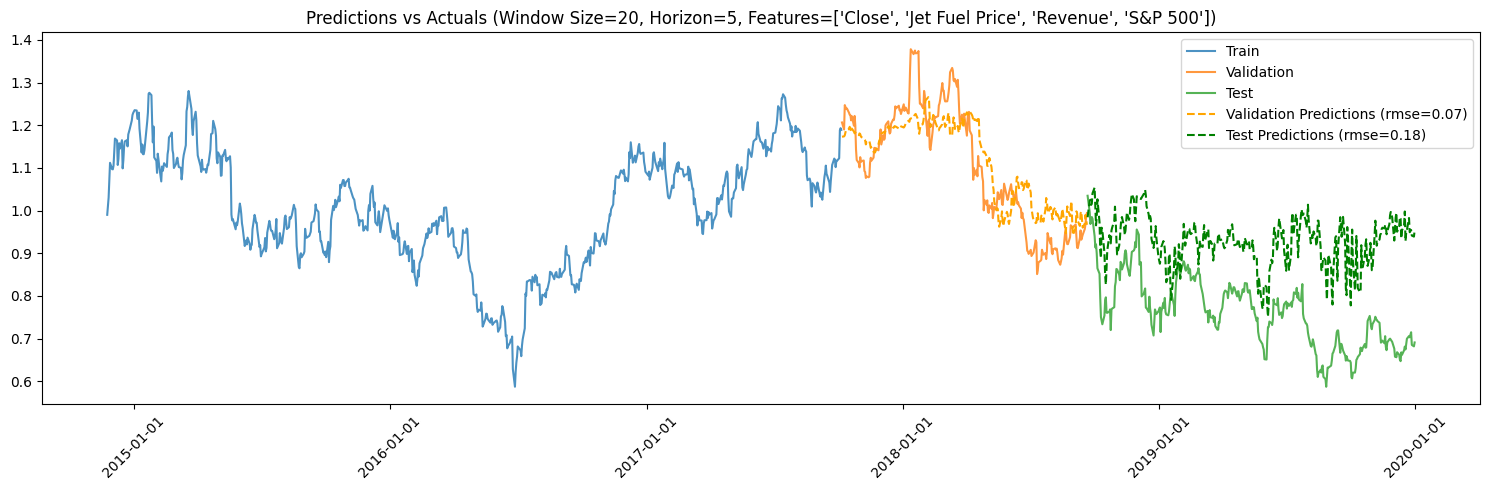

In [ ]:
plot_predictions_with_actuals(train_preds, val_preds, test_preds,
                                train_rmse, val_rmse, test_rmse,
                                train_df, val_df, test_df,
                                window_size, H, use_cols)

In [ ]:
# save predictions on test set to new df
test_preds_flat = np.concatenate(test_preds).flatten()
test_dates = test_df['Date'].values

test_preds_df = pd.DataFrame({'Date': test_dates, 'Close': test_preds_flat})
test_preds_df.to_csv(pred_path + f'LSTM_5_ex.csv', index=False)

## Horizon = 21 (work month)

In [ ]:
H = 21
window_size = 20
use_cols = [0]
batch_size = 4

(train_dataset, train_loader), (val_dataset, val_loader), (test_dataset, test_loader) = create_datasets_and_loaders(
    train_array=train_array,
    val_array=val_array,
    test_array=test_array,
    H=H,
    window_size=window_size,
    use_cols=use_cols,
    batch_size=batch_size
)

# How to access the data in the DataLoader
for input_data, label in train_loader:
    print(input_data.shape, label.shape)
    break

torch.Size([4, 20, 1]) torch.Size([4])


In [ ]:
study = run_optuna_with_progress(objective, H, use_cols, n_trials=10, seed=42, direction='minimize')

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [14:50<2:13:30, 890.05s/it]

Trial 0: hidden_size=32, num_layers=1, dropout=0.41, lr=0.00586, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 20%|██        | 2/10 [32:46<2:13:18, 999.81s/it]

Trial 1: hidden_size=32, num_layers=3, dropout=0.05, lr=0.00742, batch_size=8, best_val_rmse=0.0923, test_rmse=0.1377


 30%|███       | 3/10 [44:36<1:41:10, 867.20s/it]

Trial 2: hidden_size=64, num_layers=2, dropout=0.29, lr=0.00539, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 40%|████      | 4/10 [56:31<1:20:44, 807.41s/it]

Trial 3: hidden_size=32, num_layers=1, dropout=0.09, lr=0.00894, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 50%|█████     | 5/10 [1:14:37<1:15:39, 907.92s/it]

Trial 4: hidden_size=96, num_layers=3, dropout=0.38, lr=0.00656, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


 60%|██████    | 6/10 [1:27:37<57:37, 864.33s/it]  

Trial 5: hidden_size=96, num_layers=3, dropout=0.13, lr=0.00757, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 70%|███████   | 7/10 [1:39:31<40:45, 815.03s/it]

Trial 6: hidden_size=32, num_layers=1, dropout=0.46, lr=0.00532, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 80%|████████  | 8/10 [1:59:42<31:22, 941.24s/it]

Trial 7: hidden_size=64, num_layers=1, dropout=0.46, lr=0.00671, batch_size=4, best_val_rmse=0.0945, test_rmse=0.1246


 90%|█████████ | 9/10 [2:16:26<16:00, 960.79s/it]

Trial 8: hidden_size=64, num_layers=2, dropout=0.06, lr=0.00591, batch_size=8, best_val_rmse=1.1106, test_rmse=0.7658


100%|██████████| 10/10 [2:40:01<00:00, 960.12s/it] 

Trial 9: hidden_size=64, num_layers=2, dropout=0.20, lr=0.00972, batch_size=4, best_val_rmse=1.1106, test_rmse=0.7658

Best hyperparameters: {'hidden_size': 32, 'num_layers': 3, 'dropout': 0.050777355185361917, 'lr': 0.007418257352604289, 'batch_size': 8}
Best RMSE: 0.09232776612043381


In [ ]:
results = train_and_evaluate_lstm_model(
    study_best_params=study.best_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    use_cols=use_cols,
    H=H,
    device=device
)

# Access train, val, and test results
# rmses
train_rmse, val_rmse, test_rmse = results['train']['rmse'], results['val']['rmse'], results['test']['rmse']
# preds
train_preds, val_preds, test_preds = results['train']['preds'], results['val']['preds'], results['test']['preds']

Epoch [1/400]: Val Loss=0.0363, Val RMSE=0.1933 (Best RMSE=0.1933)
Epoch [2/400]: Val Loss=0.0224, Val RMSE=0.1516 (Best RMSE=0.1516)
Epoch [3/400]: Val Loss=0.0246, Val RMSE=0.1590 (Best RMSE=0.1516)
Epoch [4/400]: Val Loss=0.0112, Val RMSE=0.1069 (Best RMSE=0.1069)
Epoch [5/400]: Val Loss=0.0118, Val RMSE=0.1101 (Best RMSE=0.1069)
Epoch [6/400]: Val Loss=0.0106, Val RMSE=0.1045 (Best RMSE=0.1045)
Epoch [7/400]: Val Loss=0.0213, Val RMSE=0.1466 (Best RMSE=0.1045)
Epoch [8/400]: Val Loss=0.0163, Val RMSE=0.1275 (Best RMSE=0.1045)
Epoch [9/400]: Val Loss=0.0099, Val RMSE=0.1011 (Best RMSE=0.1011)
Epoch [10/400]: Val Loss=0.0096, Val RMSE=0.0984 (Best RMSE=0.0984)
Epoch [11/400]: Val Loss=0.0311, Val RMSE=0.1774 (Best RMSE=0.0984)
Epoch [12/400]: Val Loss=0.0123, Val RMSE=0.1116 (Best RMSE=0.0984)
Epoch [13/400]: Val Loss=0.0161, Val RMSE=0.1277 (Best RMSE=0.0984)
Epoch [14/400]: Val Loss=0.0128, Val RMSE=0.1134 (Best RMSE=0.0984)
Epoch [15/400]: Val Loss=0.0240, Val RMSE=0.1552 (Best RM

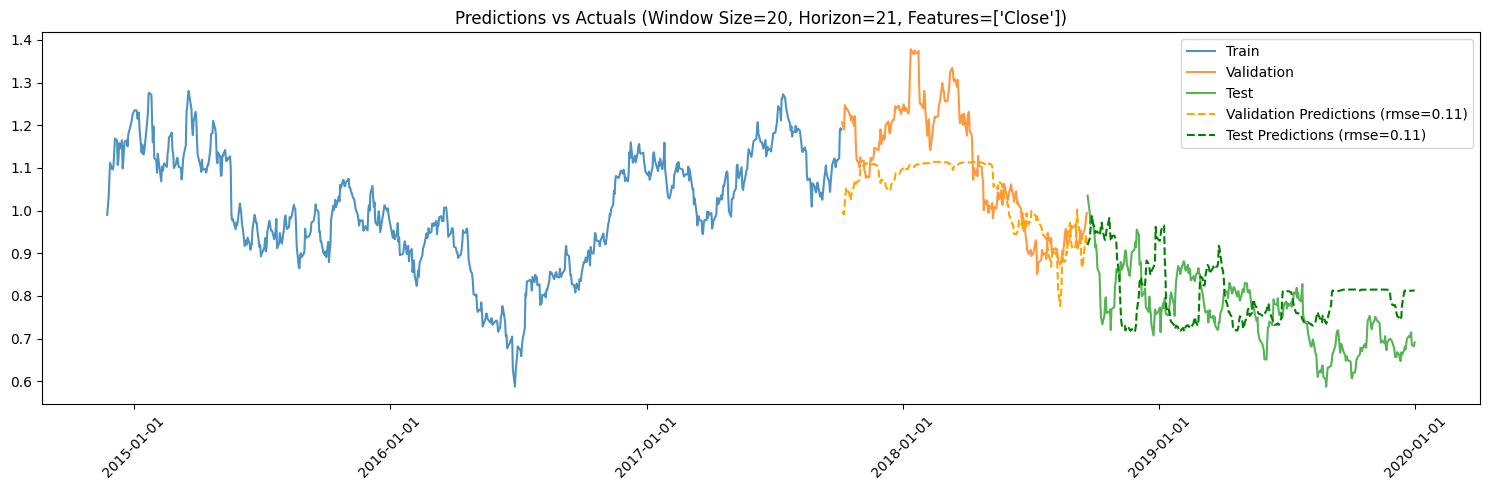

In [ ]:
plot_predictions_with_actuals(train_preds, val_preds, test_preds,
                                train_rmse, val_rmse, test_rmse,
                                train_df, val_df, test_df,
                                window_size, H, use_cols)

In [ ]:
# save predictions on test set to new df
test_preds_flat = np.concatenate(test_preds).flatten()
test_dates = test_df['Date'].values

test_preds_df = pd.DataFrame({'Date': test_dates, 'Close': test_preds_flat})
test_preds_df.to_csv(pred_path + f'LSTM_21.csv', index=False)

### More Features

In [ ]:
H = 21
window_size = 20
use_cols = [0, 2, 3, 5]
batch_size = 4

(train_dataset, train_loader), (val_dataset, val_loader), (test_dataset, test_loader) = create_datasets_and_loaders(
    train_array=train_array,
    val_array=val_array,
    test_array=test_array,
    H=H,
    window_size=window_size,
    use_cols=use_cols,
    batch_size=batch_size
)

# How to access the data in the DataLoader
for input_data, label in train_loader:
    print(input_data.shape, label.shape)
    break

torch.Size([4, 20, 4]) torch.Size([4])


In [ ]:
study = run_optuna_with_progress(objective, H, use_cols, n_trials=10, seed=42, direction='minimize')

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [22:41<3:24:15, 1361.70s/it]

Trial 0: hidden_size=64, num_layers=2, dropout=0.33, lr=0.00731, batch_size=4, best_val_rmse=0.1099, test_rmse=0.3617


 20%|██        | 2/10 [43:27<2:52:27, 1293.41s/it]

Trial 1: hidden_size=32, num_layers=1, dropout=0.19, lr=0.00768, batch_size=4, best_val_rmse=0.0993, test_rmse=0.4329


 30%|███       | 3/10 [56:20<2:03:11, 1055.88s/it]

Trial 2: hidden_size=96, num_layers=3, dropout=0.50, lr=0.00791, batch_size=16, best_val_rmse=0.0819, test_rmse=0.2603


 40%|████      | 4/10 [1:20:42<2:01:36, 1216.12s/it]

Trial 3: hidden_size=64, num_layers=3, dropout=0.11, lr=0.00781, batch_size=4, best_val_rmse=0.1158, test_rmse=0.3536


 50%|█████     | 5/10 [1:33:01<1:27:01, 1044.29s/it]

Trial 4: hidden_size=32, num_layers=1, dropout=0.38, lr=0.00838, batch_size=16, best_val_rmse=0.0995, test_rmse=0.2338


 60%|██████    | 6/10 [1:44:59<1:02:12, 933.24s/it] 

Trial 5: hidden_size=32, num_layers=2, dropout=0.49, lr=0.00567, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 70%|███████   | 7/10 [2:09:24<55:21, 1107.03s/it] 

Trial 6: hidden_size=96, num_layers=3, dropout=0.28, lr=0.00863, batch_size=4, best_val_rmse=0.1066, test_rmse=0.3535


 80%|████████  | 8/10 [2:24:34<34:48, 1044.35s/it]

Trial 7: hidden_size=64, num_layers=4, dropout=0.18, lr=0.00878, batch_size=16, best_val_rmse=1.1106, test_rmse=0.7658


 90%|█████████ | 9/10 [2:49:58<19:54, 1194.24s/it]

Trial 8: hidden_size=32, num_layers=4, dropout=0.29, lr=0.00628, batch_size=4, best_val_rmse=0.1163, test_rmse=0.3684


100%|██████████| 10/10 [3:02:41<00:00, 1096.11s/it]

Trial 9: hidden_size=64, num_layers=2, dropout=0.44, lr=0.00598, batch_size=4, best_val_rmse=0.1015, test_rmse=0.4706

Best hyperparameters: {'hidden_size': 96, 'num_layers': 3, 'dropout': 0.49737097663935975, 'lr': 0.007908450335582962, 'batch_size': 16}
Best RMSE: 0.08187247067689896


In [ ]:
results = train_and_evaluate_lstm_model(
    study_best_params=study.best_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    use_cols=use_cols,
    H=H,
    device=device
)

# Access train, val, and test results
# rmses
train_rmse, val_rmse, test_rmse = results['train']['rmse'], results['val']['rmse'], results['test']['rmse']
# preds
train_preds, val_preds, test_preds = results['train']['preds'], results['val']['preds'], results['test']['preds']

Epoch [1/400]: Val Loss=0.0251, Val RMSE=0.1632 (Best RMSE=0.1632)
Epoch [2/400]: Val Loss=0.0403, Val RMSE=0.2066 (Best RMSE=0.1632)
Epoch [3/400]: Val Loss=0.0234, Val RMSE=0.1574 (Best RMSE=0.1574)
Epoch [4/400]: Val Loss=0.0195, Val RMSE=0.1421 (Best RMSE=0.1421)
Epoch [5/400]: Val Loss=0.0195, Val RMSE=0.1409 (Best RMSE=0.1409)
Epoch [6/400]: Val Loss=0.0185, Val RMSE=0.1383 (Best RMSE=0.1383)
Epoch [7/400]: Val Loss=0.0191, Val RMSE=0.1385 (Best RMSE=0.1383)
Epoch [8/400]: Val Loss=0.0182, Val RMSE=0.1351 (Best RMSE=0.1351)
Epoch [9/400]: Val Loss=0.0224, Val RMSE=0.1495 (Best RMSE=0.1351)
Epoch [10/400]: Val Loss=0.0412, Val RMSE=0.2005 (Best RMSE=0.1351)
Epoch [11/400]: Val Loss=0.0176, Val RMSE=0.1336 (Best RMSE=0.1336)
Epoch [12/400]: Val Loss=0.0158, Val RMSE=0.1278 (Best RMSE=0.1278)
Epoch [13/400]: Val Loss=0.0174, Val RMSE=0.1357 (Best RMSE=0.1278)
Epoch [14/400]: Val Loss=0.0202, Val RMSE=0.1461 (Best RMSE=0.1278)
Epoch [15/400]: Val Loss=0.0175, Val RMSE=0.1330 (Best RM

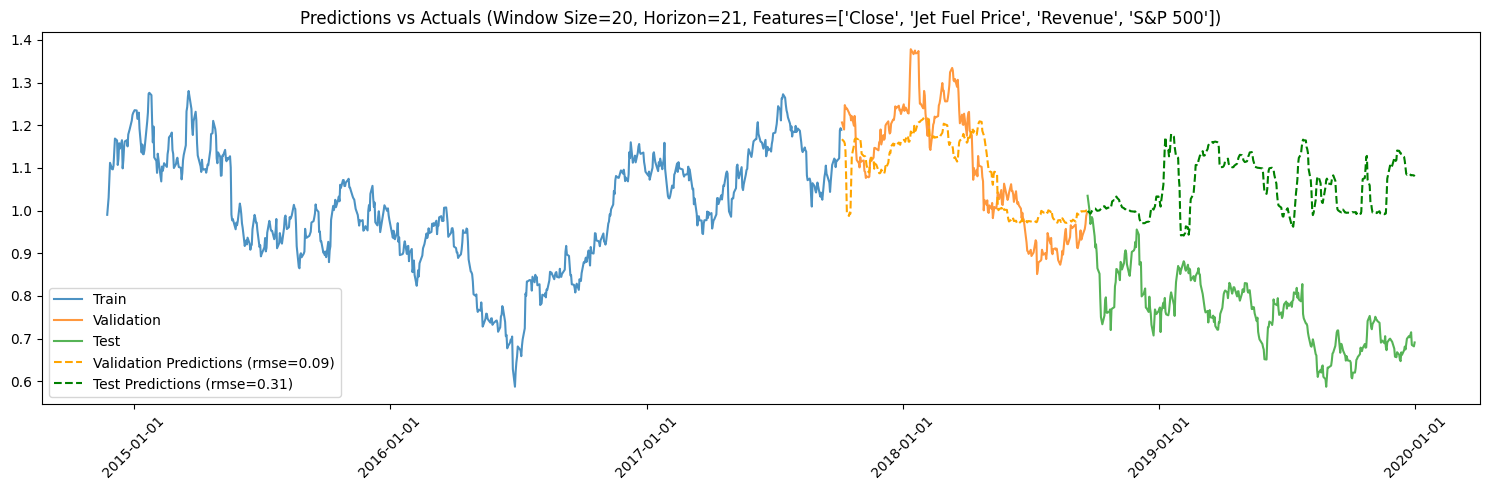

In [ ]:
plot_predictions_with_actuals(train_preds, val_preds, test_preds,
                                train_rmse, val_rmse, test_rmse,
                                train_df, val_df, test_df,
                                window_size, H, use_cols)

In [ ]:
# save predictions on test set to new df
test_preds_flat = np.concatenate(test_preds).flatten()
test_dates = test_df['Date'].values

test_preds_df = pd.DataFrame({'Date': test_dates, 'Close': test_preds_flat})
test_preds_df.to_csv(pred_path + f'LSTM_21_ex.csv', index=False)